## Notebook Setup

In [1]:
# Import python coding libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, SimpleRNN, LSTM, GRU, Reshape, Activation, Bidirectional, LeakyReLU
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc, log_loss, accuracy_score, classification_report, matthews_corrcoef


# Seeting random seeds to duplicate results
np.random.seed(2)
tf.random.set_seed(2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# Notebook display settings
desired_width = 600
display_columns = 300
width = 100
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth = desired_width)
pd.set_option('display.max_columns', display_columns)
pd.set_option('display.max_colwidth', None)

## Load Data

In [3]:
# Load and view the training data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

PassengerId  Survived  Pclass                                                 Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0            1         0       3                              Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1            2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1      0          PC 17599  71.2833   C85        C
2            3         1       3                               Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3            4         1       1         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4            5         0       3                             Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S

In [5]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

PassengerId  Pclass                                          Name     Sex   Age  SibSp  Parch   Ticket     Fare Cabin Embarked
0          892       3                              Kelly, Mr. James    male  34.5      0      0   330911   7.8292   NaN        Q
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female  47.0      1      0   363272   7.0000   NaN        S
2          894       2                     Myles, Mr. Thomas Francis    male  62.0      0      0   240276   9.6875   NaN        Q
3          895       3                              Wirz, Mr. Albert    male  27.0      0      0   315154   8.6625   NaN        S
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female  22.0      1      1  3101298  12.2875   NaN        S

## Exploratory Data Analysis

In [7]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

sum_women = sum(women) # My code
deceased_women = rate_women * sum_women # My code

print("# of women:", sum_women) # My code
print("% of women who survived:", round(rate_women * 100,1),"%") # Partially my code
print("# of deceased women:", round(deceased_women,0))  # My code

# of women: 233
% of women who survived: 74.2 %
# of deceased women: 173.0


In [8]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

sum_men = sum(men) # My code
deceased_men = rate_men * sum_men # My code

print("# of men", sum_men)
print("% of men who survived:", round(rate_men * 100,1),"%") # Partially my code
print("# of deceased men:", round(deceased_men,0)) # My code

# of men 109
% of men who survived: 18.9 %
# of deceased men: 21.0


In [9]:
# Get info on training data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Format Training Data

In [10]:
def get_formatted_data(df):
    """Format traing and testing data."""
    
    # Fix ALL Nan issues
    df = df.replace(np.nan, 'Unknown', regex=True)
    
    # Convert the 'Fare' column to a numeric data type
    df['Fare'] = pd.to_numeric(df['Fare'], errors='coerce')
    
    # Bucket Fares and one-hot encode them
    bins = [0, 20, 50, 100, 250, 500]
    df['Fare_bucket'] = pd.cut(df['Fare'], bins=bins)
    
    # One-hot encode the Fare_bucket column
    df_fare_buckets = pd.get_dummies(df['Fare_bucket'], prefix='Fare')
    df = pd.concat([df, df_fare_buckets], axis=1)
    
    # Changing Unknown Age to median based on sex
    df['Age'].replace('Unknown', np.nan, inplace=True)
    df['Age'] = df['Age'].astype(float)
    group_median_ages = df.groupby('Sex')['Age'].median()

    def impute_age(row):
        if pd.isnull(row['Age']):
            return group_median_ages[row['Sex']]
        return row['Age']

    df['Age'] = df.apply(impute_age, axis=1)
    
    # Create year bins to group age and one-hot encode them
    df['age_group'] = pd.cut(df['Age'], bins=[0, 13, 50, 70], labels=False, include_lowest=True)
    df_age_groups = pd.get_dummies(df['age_group'], prefix='age_group')
    df = pd.concat([df, df_age_groups], axis=1)
    
    # Custom function to get the first character
    def get_first_character(text):
        return text[0]

    # Create a new column with the first character from 'column1'
    df['CabinLetter'] = df['Cabin'].apply(get_first_character)
    
    # Columns to Drop that are not required for ML
    cols_to_drop = ['Name', 'Ticket', 'Fare', 'Age', 'age_group', 'Cabin', 'Fare_bucket']
    df = df.drop(cols_to_drop, axis=1)
    
    # One-hot encode 'Pclass','Sex','SibSp','Parch','Embarked'
    df = pd.get_dummies(df, columns=['Pclass','Sex','SibSp','Parch','Embarked', 'CabinLetter'])

    return df

In [11]:
# Format the training data
formatted_training_data = get_formatted_data(train_data)
formatted_training_data.head()

PassengerId  Survived  Fare_(0, 20]  Fare_(20, 50]  Fare_(50, 100]  Fare_(100, 250]  Fare_(250, 500]  age_group_0.0  age_group_1.0  age_group_2.0  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  SibSp_0  SibSp_1  SibSp_2  SibSp_3  SibSp_4  SibSp_5  SibSp_8  Parch_0  Parch_1  Parch_2  Parch_3  Parch_4  Parch_5  Parch_6  Embarked_C  Embarked_Q  Embarked_S  Embarked_Unknown  CabinLetter_A  CabinLetter_B  CabinLetter_C  CabinLetter_D  CabinLetter_E  CabinLetter_F  CabinLetter_G  CabinLetter_T  CabinLetter_U
0            1         0             1              0               0                0                0              0              1              0         0         0         1           0         1        0        1        0        0        0        0        0        1        0        0        0        0        0        0           0           0           1                 0              0              0              0              0              0              0              0              0              1
1            2         1             0              0               1                0                0              0              1              0         1         0         0           1         0        0        1        0        0        0        0        0        1        0        0        0        0        0        0           1           0           0                 0              0              0              1              0              0              0              0              0              0
2            3         1             1              0               0                0                0              0              1              0         0         0         1           1         0        1        0        0        0        0        0        0        1        0        0        0        0        0        0           0           0           1                 0              0              0              0              0              0              0              0              0              1
3            4         1             0              0               1                0                0              0              1              0         1         0         0           1         0        0        1        0        0        0        0        0        1        0        0        0        0        0        0           0           0           1                 0              0              0              1              0              0              0              0              0              0
4            5         0             1              0               0                0                0              0              1              0         0         0         1           0         1        1        0        0        0        0        0        0        1        0        0        0        0        0        0           0           0           1                 0              0              0              0              0              0              0              0              0              1

In [12]:
# Separate into features and labels for machine learning
features = formatted_training_data.drop('Survived', axis=1)
labels = formatted_training_data['Survived']

## Format Testing Data

In [13]:
formatted_testing_data = get_formatted_data(test_data)

# Add new column 'NewColumn' with all values set to 0
formatted_testing_data['CabinLetter_T'] = 0

# Reorder columns to place 'NewColumn' at a specific position (e.g., 1)
column_order = formatted_testing_data.columns.tolist()
column_order.insert(38, column_order.pop(column_order.index('CabinLetter_T')))
formatted_testing_data = formatted_testing_data[column_order]

formatted_testing_data.head()

PassengerId  Fare_(0, 20]  Fare_(20, 50]  Fare_(50, 100]  Fare_(100, 250]  Fare_(250, 500]  age_group_0.0  age_group_1.0  age_group_2.0  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  SibSp_0  SibSp_1  SibSp_2  SibSp_3  SibSp_4  SibSp_5  SibSp_8  Parch_0  Parch_1  Parch_2  Parch_3  Parch_4  Parch_5  Parch_6  Parch_9  Embarked_C  Embarked_Q  Embarked_S  CabinLetter_A  CabinLetter_B  CabinLetter_C  CabinLetter_D  CabinLetter_E  CabinLetter_F  CabinLetter_T  CabinLetter_G  CabinLetter_U
0          892             1              0               0                0                0              0              1              0         0         0         1           0         1        1        0        0        0        0        0        0        1        0        0        0        0        0        0        0           0           1           0              0              0              0              0              0              0              0              0              1
1          893             1              0               0                0                0              0              1              0         0         0         1           1         0        0        1        0        0        0        0        0        1        0        0        0        0        0        0        0           0           0           1              0              0              0              0              0              0              0              0              1
2          894             1              0               0                0                0              0              0              1         0         1         0           0         1        1        0        0        0        0        0        0        1        0        0        0        0        0        0        0           0           1           0              0              0              0              0              0              0              0              0              1
3          895             1              0               0                0                0              0              1              0         0         0         1           0         1        1        0        0        0        0        0        0        1        0        0        0        0        0        0        0           0           0           1              0              0              0              0              0              0              0              0              1
4          896             1              0               0                0                0              0              1              0         0         0         1           1         0        0        1        0        0        0        0        0        0        1        0        0        0        0        0        0           0           0           1              0              0              0              0              0              0              0              0              1

## Machine Learning

In [14]:
def get_classification_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Display accuracy, log-loss, classification report, confusion matrix, and the Receiver Operating Characteristic (ROC)) curve"""
    
    # Import statements
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import (log_loss, classification_report, confusion_matrix, roc_curve, 
                                 roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay)
    
    # Get the train and test accuracy scores
    print(f">> Training - Accuracy: {model.score(X_train, y_train) * 100:.2f}%")
    print(f">> Validation - Accuracy: {model.score(X_val, y_val) * 100:.2f}%")
    print(f">> Testing - Accuracy: {model.score(X_test, y_test) * 100:.2f}%")

    # Get the train and test logloss results
    print(f">> Training - LogLoss: {round(log_loss(y_train, model.predict_proba(X_train)), 4)}")
    print(f">> Validation - LogLoss: {round(log_loss(y_val, model.predict_proba(X_val)), 4)}")
    print(f">> Testing - LogLoss: {round(log_loss(y_test, model.predict_proba(X_test)), 4)}")
    
    # Evaluate model on test data
    y_pred = model.predict(X_test)
    
    # Calculate the MCC for testing data
    mcc = matthews_corrcoef(y_test, y_pred)
    print()
    print(f">> Testing - MCC: {mcc}")
    print()    

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    classification_report_df = pd.DataFrame(report).transpose()
    print(classification_report(y_test, y_pred))

    # Customize the report
    classification_report_df = classification_report_df.drop('support', axis=1)
    classification_report_df = classification_report_df.round(decimals=2)

    # Create a heatmap of the scores
    ax = sns.heatmap(classification_report_df, annot=True, cmap='Blues', fmt='g')

    # Add labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Classes')
    ax.set_title('Classification Report')
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    cm_display = ConfusionMatrixDisplay(cm).plot()
    plt.title("Confusion Matrix")
    plt.show()

    # Compute ROC curve and AUC score
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

In [15]:
# Splitting the data into training, validation, and testing datasets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.4, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10)

### Logistic Classification

In [16]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter': [100, 500, 1000, 2000],
    'class_weight': [None, 'balanced']
}

# Create a LogisticRegression object
lr = LogisticRegression(random_state=10, max_iter=1000)

# Create a GridSearchCV object
grid_search = GridSearchCV(lr, param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.812784341385999


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.59925939 0.59925939 0.59925939 0.60673603        nan        nan        nan 0.80155175 0.81089755        nan        nan        nan 0.59925939 0.59925939 0.59925939 0.60673603        nan        nan        nan 0.80155175 0.80717686        nan        nan        nan 0.59925939 0.59925939 0.59925939 0.60673603        nan        nan        nan 0.80155175 0.80342091        nan        nan        nan 0.59925939 0.59925939 0.59925939 0.60673603        nan        nan        nan 0.80155175 0.80342091        nan        nan        nan 0.56000705 0.68904955 0.68904955 0.74157997
        nan        nan        nan 0.79594428 0.80527244        nan        nan        nan 0.56000705 0.68904955 0.68904955 0.74157997        nan        nan        nan 0.79594428 0.79781344        nan        nan        nan 0.56000705 0.68904955 0.68904955 0.74157997  

In [49]:
# Optimal LC Model
# Train a LinearRegression model with the best Hyperparameters from GridSearch
lr2 = LogisticRegression(random_state = 10, 
                         max_iter = 100, 
                         solver = 'liblinear', 
                         penalty='l2', 
                         class_weight=None, 
                         C=1)

# Fit the model to the traning data
lr2.fit(X_train, y_train)
print(">>> Logistic Regression model has been trained.")

# Make predictions using the test data
y_pred = lr2.predict(X_test)

>>> Logistic Regression model has been trained.


>> Training - Accuracy: 81.84%
>> Validation - Accuracy: 74.72%
>> Testing - Accuracy: 78.21%
>> Training - LogLoss: 0.4265
>> Validation - LogLoss: 0.4985
>> Testing - LogLoss: 0.4465

>> Testing - MCC: 0.5254647880858926

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       118
           1       0.67      0.72      0.69        61

    accuracy                           0.78       179
   macro avg       0.76      0.77      0.76       179
weighted avg       0.79      0.78      0.78       179



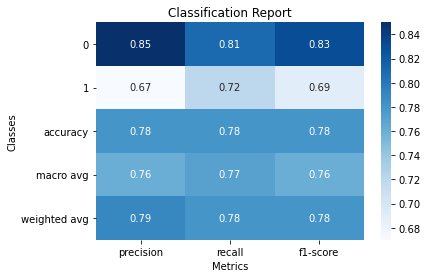

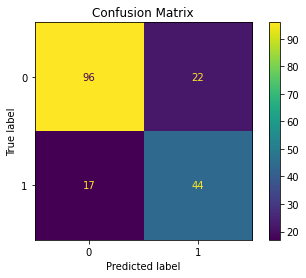

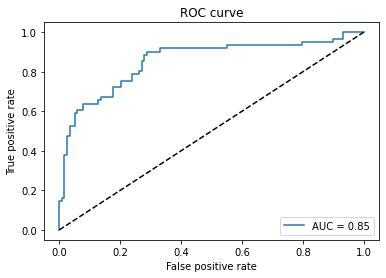

In [50]:
get_classification_metrics(lr2, X_train, y_train, X_val, y_val, X_test, y_test)

### Random Forest

In [21]:
# Initializing a DataFrame to save each model results
rf_results = pd.DataFrame()

# Length of features
feature_length = len(features)

# % of max features to use
max_features_params = [0.2, 0.4, 0.6, 0.8]

# Loop to use different parameters in the model
#for f in np.arange(2, feature_length * 0.8, 5):
for f in max_features_params:
    for e in np.arange(10, 350, 20):
        # Create Random Forest model
        clf = RandomForestClassifier(max_features=f,
                                     random_state=0,
                                     max_depth = 8,
                                     n_estimators=e)
        
        # Fit and train the model using the training data
        clf.fit(X_train, y_train.values.ravel())
        
        # Score the model based on 'cv' folds
        clf_scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=5)
        
        # Score the model on the test data
        y_pred = clf.predict(X_test)
        accuracy = clf.score(X_test, y_test)
        
        # Calculate the MCC for testing data
        mcc = matthews_corrcoef(y_test, y_pred)
        
        # Calculate the log loss for training and testing data
        y_train_proba = clf.predict_proba(X_train)
        train_log_loss = log_loss(y_train, y_train_proba)
        
        y_test_proba = clf.predict_proba(X_test)
        test_log_loss = log_loss(y_test, y_test_proba)
        
        # Print average scores and +/- two standard deviations away (covering 95% of tests)
        print(">> max_features: %s, num_estimators: %i, Train Accuracy: %0.4f (+/- %0.3f), Test Accuracy: %0.4f, Test MCC: %0.4f, Train Log Loss: %0.4f, Test Log Loss: %0.4f" % (str(f), e, clf_scores.mean(), clf_scores.std() * 2, accuracy, mcc, train_log_loss, test_log_loss))
        
        # New row for results dataframe containing model hyperparameters and results
        new_row = {'model_type': type(clf).__name__,
                   'max_features': f,
                   'num_estimators': e,
                   'train_accuracy': clf_scores.mean(),
                   'train_accuracy_std': clf_scores.std(),
                   'test_accuracy': accuracy,
                   'mcc': mcc,
                   'train_log_loss': train_log_loss,
                   'test_log_loss': test_log_loss}
        
        rf_results = rf_results.append(new_row, ignore_index=True)

>> max_features: 0.2, num_estimators: 10, Train Accuracy: 0.7846 (+/- 0.060), Test Accuracy: 0.7877, Test MCC: 0.5239, Train Log Loss: 0.2927, Test Log Loss: 0.4606
>> max_features: 0.2, num_estimators: 30, Train Accuracy: 0.8015 (+/- 0.114), Test Accuracy: 0.7877, Test MCC: 0.5175, Train Log Loss: 0.2757, Test Log Loss: 0.4619
>> max_features: 0.2, num_estimators: 50, Train Accuracy: 0.7996 (+/- 0.119), Test Accuracy: 0.7877, Test MCC: 0.5175, Train Log Loss: 0.2763, Test Log Loss: 0.4520
>> max_features: 0.2, num_estimators: 70, Train Accuracy: 0.7996 (+/- 0.106), Test Accuracy: 0.7933, Test MCC: 0.5317, Train Log Loss: 0.2785, Test Log Loss: 0.4519
>> max_features: 0.2, num_estimators: 90, Train Accuracy: 0.7959 (+/- 0.123), Test Accuracy: 0.7933, Test MCC: 0.5348, Train Log Loss: 0.2794, Test Log Loss: 0.4510
>> max_features: 0.2, num_estimators: 110, Train Accuracy: 0.7959 (+/- 0.121), Test Accuracy: 0.7933, Test MCC: 0.5317, Train Log Loss: 0.2782, Test Log Loss: 0.4465
>> max_fe

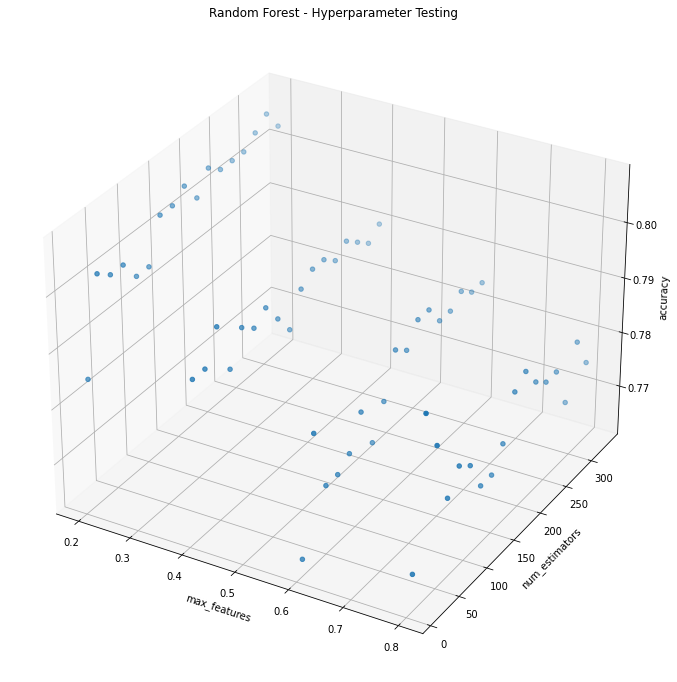

In [22]:
# Data for a three-dimensional scattered points plot
x = rf_results['max_features'].tolist()
y = rf_results['num_estimators'].tolist()     # test removing .tolist() on all three lines
z = rf_results['train_accuracy'].tolist()

# Figure properties
fig = plt.figure(figsize= (16,12))
ax = plt.axes(projection = "3d")

# Creating plot
ax.scatter3D(x, y, z, cmap = 'Greens')
plt.title("Random Forest - Hyperparameter Testing")
ax.set_xlabel('max_features')
ax.set_ylabel('num_estimators')
ax.set_zlabel('accuracy')
plt.show()

In [25]:
#Optimal RF
# Length of features
feature_length = len(features)

# Model
rfc = RandomForestClassifier(n_estimators = 280,
                             max_features = 0.2,
                             max_depth = 10,
                             random_state = 1)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=0.2, n_estimators=280,
                       random_state=1)

In [ ]:
get_classification_metrics(rfc, X_train, y_train, X_val, y_val, X_test, y_test)

### Neural Netwrok

In [30]:
# Define function to select optimizer and learning rate
def select_optimizer(optimize, learn):
    """Used to select an optimizer and learning rate."""
    import tensorflow as tf
    
    optimizer_dict = {'Adam': tf.optimizers.Adam(learning_rate = learn),
                      'SGD': tf.optimizers.SGD(learning_rate = learn),
                      'Adadelta': tf.optimizers.Adadelta(learning_rate = learn),
                      'RMSprop': tf.optimizers.RMSprop(learning_rate = learn),
                      'Adagrad': tf.optimizers.Adagrad(learning_rate = learn),
                      'Adamax': tf.optimizers.Adamax(learning_rate = learn),
                      'Nadam': tf.optimizers.Nadam(learning_rate = learn),
                      'Ftrl': tf.optimizers.Ftrl(learning_rate = learn),
                      }
    
    return optimizer_dict[optimize]

In [31]:
# Finding the shape for input_dim
print(f"The shape of the dataset: {X_train.shape}")
dims = X_train.shape[1]
print(f'Dimensions:{dims}')

The shape of the dataset: (534, 41)
Dimensions:41


Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 20.8515 - accuracy: 0.4660 - val_loss: 4.3098 - val_accuracy: 0.4019
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 21.8217 - accuracy: 0.4965 - val_loss: 3.1019 - val_accuracy: 0.4299
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 20.7623 - accuracy: 0.4704 - val_loss: 2.0446 - val_accuracy: 0.4299
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 21.2826 - accuracy: 0.4991 - val_loss: 1.2513 - val_accuracy: 0.4673
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 21.0324 - accuracy: 0.4906 - val_loss: 0.7546 - val_accuracy: 0.5514
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 21.0282 - accuracy: 0.4195 - val_loss: 0.8004 - val_accuracy: 0.6262
Epoch 7/350
14/14 [==============================] - 0s 5ms/step - loss: 18.6111 - accuracy: 0.4812 - val_loss: 1.0346 - val_accuracy: 0.6262
Epoch

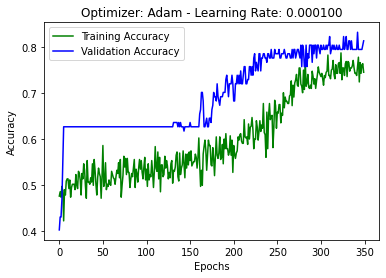

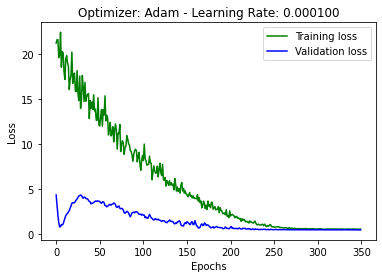

The training accuracy is: 0.8108614087104797
The training loss is: 0.4596869647502899
The testing accuracy is: 0.7597765363128491
The testing loss is: 0.44819727540016174

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 27.8314 - accuracy: 0.5720 - val_loss: 26.7378 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 25.7217 - accuracy: 0.5857 - val_loss: 17.7468 - val_accuracy: 0.6168
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 22.6133 - accuracy: 0.5239 - val_loss: 12.2124 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 21.5498 - accuracy: 0.5121 - val_loss: 8.0414 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 20.3315 - accuracy: 0.5224 - val_loss: 5.7795 - val_accuracy: 0.6355
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 17.3484 - accuracy: 0.5018 - val_loss: 5.

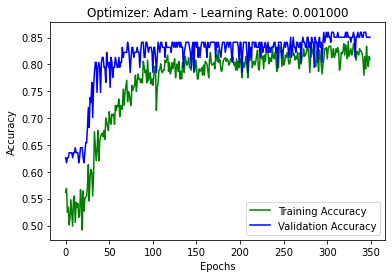

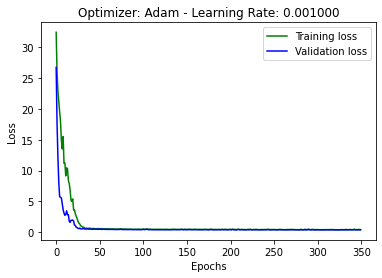

The training accuracy is: 0.8408239483833313
The training loss is: 0.4000600576400757
The testing accuracy is: 0.776536312849162
The testing loss is: 0.5004855394363403

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 43.9389 - accuracy: 0.4805 - val_loss: 14.3561 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 20.5631 - accuracy: 0.5249 - val_loss: 1.5890 - val_accuracy: 0.4579
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 13.2212 - accuracy: 0.5839 - val_loss: 2.2847 - val_accuracy: 0.6355
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 4.5748 - accuracy: 0.5291 - val_loss: 0.6257 - val_accuracy: 0.6355
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 2.0140 - accuracy: 0.5811 - val_loss: 0.7218 - val_accuracy: 0.6355
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 0.7533 - accuracy: 0.6279 - val_loss: 0.7099 - 

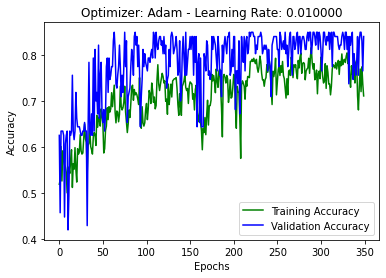

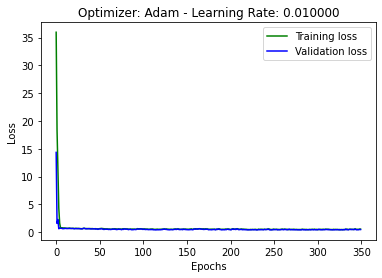

The training accuracy is: 0.8389512896537781
The training loss is: 0.4681284427642822
The testing accuracy is: 0.776536312849162
The testing loss is: 0.5478900671005249

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 61.2925 - accuracy: 0.5018 - val_loss: 0.9480 - val_accuracy: 0.4393
Epoch 2/350
14/14 [==============================] - 0s 7ms/step - loss: 1.6526 - accuracy: 0.5355 - val_loss: 0.6699 - val_accuracy: 0.6168
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 1.2672 - accuracy: 0.5197 - val_loss: 0.6991 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 1.1100 - accuracy: 0.5061 - val_loss: 0.6703 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 0.9713 - accuracy: 0.5749 - val_loss: 0.6617 - val_accuracy: 0.6168
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 1.0712 - accuracy: 0.4657 - val_loss: 0.6619 - val

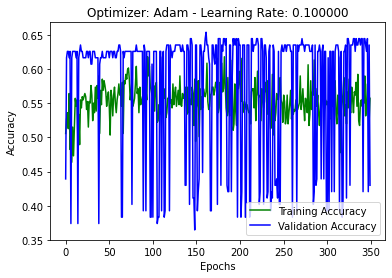

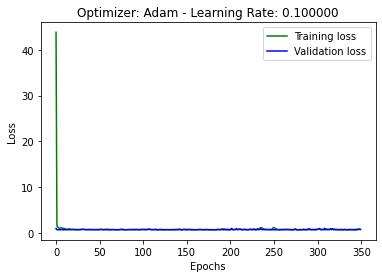

The training accuracy is: 0.44756555557250977
The training loss is: 0.6950516104698181
The testing accuracy is: 0.36312849162011174
The testing loss is: 0.7732754349708557

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 643.7036 - accuracy: 0.5585 - val_loss: 5.0730 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 9.3365 - accuracy: 0.5438 - val_loss: 2.7158 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 11.5143 - accuracy: 0.4947 - val_loss: 3.8211 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 11.4038 - accuracy: 0.4861 - val_loss: 1.6328 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 8.1995 - accuracy: 0.5376 - val_loss: 4.7309 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 7.4378 - accuracy: 0.5800 - val_loss: 3.7289

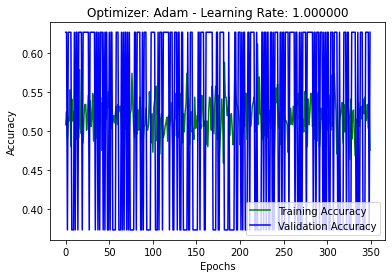

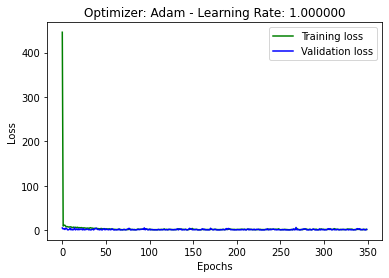

The training accuracy is: 0.5992509126663208
The training loss is: 2.22111177444458
The testing accuracy is: 0.659217877094972
The testing loss is: 1.889341950416565

Epoch 1/350
14/14 [==============================] - 1s 38ms/step - loss: 19.8454 - accuracy: 0.5846 - val_loss: 4.2324 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 23.8790 - accuracy: 0.4753 - val_loss: 1.8218 - val_accuracy: 0.5701
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 18.1383 - accuracy: 0.5017 - val_loss: 5.0277 - val_accuracy: 0.6168
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 16.7943 - accuracy: 0.4649 - val_loss: 3.4612 - val_accuracy: 0.5981
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 11.4818 - accuracy: 0.5108 - val_loss: 4.9569 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 9.5269 - accuracy: 0.5055 - val_loss: 2.1888 - va

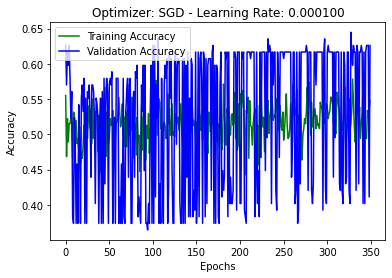

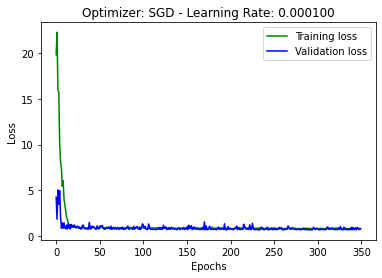

The training accuracy is: 0.6048688888549805
The training loss is: 0.7855532765388489
The testing accuracy is: 0.6536312849162011
The testing loss is: 0.7083722352981567

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 44.0827 - accuracy: 0.4703 - val_loss: 19.0578 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 10.0938 - accuracy: 0.5033 - val_loss: 3.7703 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 2.7143 - accuracy: 0.5287 - val_loss: 0.9844 - val_accuracy: 0.4766
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 1.4567 - accuracy: 0.5401 - val_loss: 0.8607 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 0.9098 - accuracy: 0.5829 - val_loss: 0.6516 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 1.0682 - accuracy: 0.5382 - val_loss: 0.6539 - 

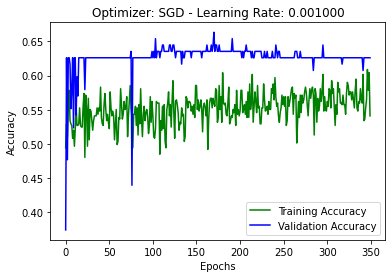

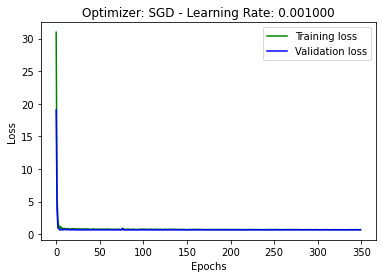

The training accuracy is: 0.6029962301254272
The training loss is: 0.6684982180595398
The testing accuracy is: 0.664804469273743
The testing loss is: 0.6426156163215637

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 96.6852 - accuracy: 0.4960 - val_loss: 3.4912 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 1.4808 - accuracy: 0.4909 - val_loss: 0.7405 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 1.1075 - accuracy: 0.4937 - val_loss: 0.6672 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 1.0048 - accuracy: 0.5432 - val_loss: 0.6574 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 1.1127 - accuracy: 0.4773 - val_loss: 0.6607 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 1.0431 - accuracy: 0.5144 - val_loss: 0.6643 - val

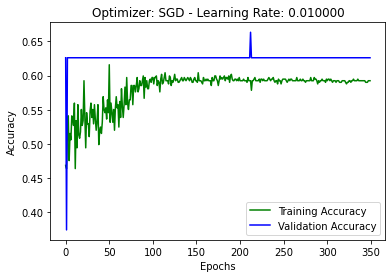

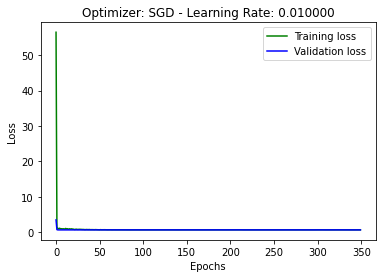

The training accuracy is: 0.5992509126663208
The training loss is: 0.6721375584602356
The testing accuracy is: 0.659217877094972
The testing loss is: 0.6495856642723083

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 1474.9866 - accuracy: 0.5849 - val_loss: 26.4439 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 59.2297 - accuracy: 0.5601 - val_loss: 25.2438 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 55.4735 - accuracy: 0.5710 - val_loss: 24.2991 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 64.4486 - accuracy: 0.5016 - val_loss: 23.4281 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 63.3064 - accuracy: 0.5039 - val_loss: 21.8811 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 57.6934 - accuracy: 0.5334 - val_loss: 

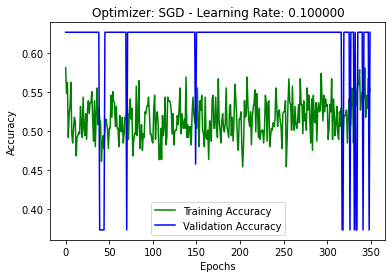

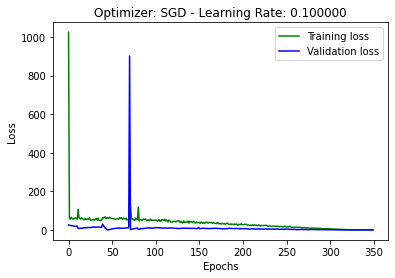

The training accuracy is: 0.5992509126663208
The training loss is: 0.6858062148094177
The testing accuracy is: 0.659217877094972
The testing loss is: 0.6421629190444946

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 314480.3962 - accuracy: 0.5122 - val_loss: 2635.8604 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 9824.1508 - accuracy: 0.4630 - val_loss: 2572.6956 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 70791.1178 - accuracy: 0.4402 - val_loss: 44670.5039 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 49849.5677 - accuracy: 0.4164 - val_loss: 44531.5938 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 49098.5721 - accuracy: 0.4725 - val_loss: 44394.6250 - val_accuracy: 0.3738
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 41539.9703 - 

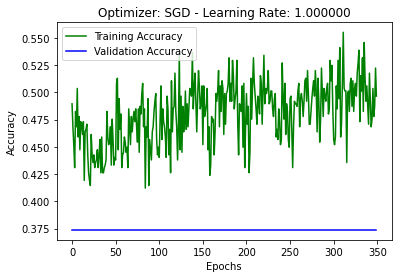

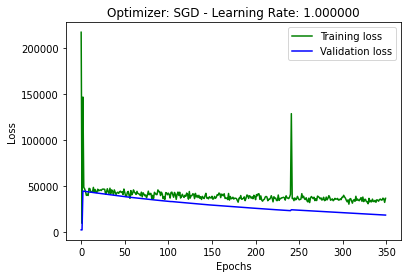

The training accuracy is: 0.4007490575313568
The training loss is: 17858.279296875
The testing accuracy is: 0.3407821229050279
The testing loss is: 19645.353515625

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 21.1122 - accuracy: 0.5516 - val_loss: 3.7449 - val_accuracy: 0.6075
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 22.8638 - accuracy: 0.4725 - val_loss: 3.7454 - val_accuracy: 0.6075
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 21.6014 - accuracy: 0.5146 - val_loss: 3.7460 - val_accuracy: 0.6075
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 24.0599 - accuracy: 0.4732 - val_loss: 3.7463 - val_accuracy: 0.6075
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 20.2704 - accuracy: 0.5537 - val_loss: 3.7467 - val_accuracy: 0.6075
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 25.8735 - accuracy: 0.4782 - val_loss: 3.7478 - val

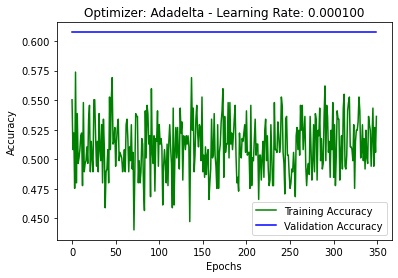

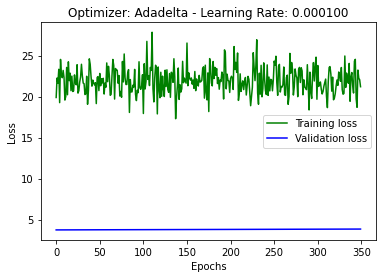

The training accuracy is: 0.601123571395874
The training loss is: 3.6417288780212402
The testing accuracy is: 0.6480446927374302
The testing loss is: 2.93696665763855

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 27.6313 - accuracy: 0.4677 - val_loss: 10.0733 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 28.5718 - accuracy: 0.4728 - val_loss: 10.0474 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 7ms/step - loss: 27.8918 - accuracy: 0.4821 - val_loss: 10.0242 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 12ms/step - loss: 30.0942 - accuracy: 0.4508 - val_loss: 9.9962 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 30.3437 - accuracy: 0.4978 - val_loss: 9.9688 - val_accuracy: 0.3738
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 28.7656 - accuracy: 0.4624 - val_loss: 9.944

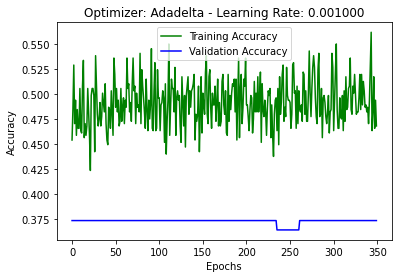

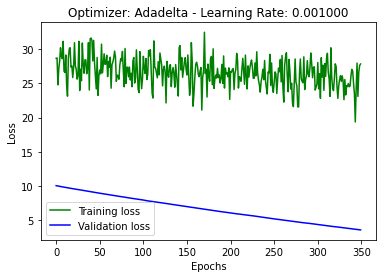

The training accuracy is: 0.4007490575313568
The training loss is: 3.5865793228149414
The testing accuracy is: 0.3407821229050279
The testing loss is: 3.541456460952759

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 36.7731 - accuracy: 0.4794 - val_loss: 29.6267 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 35.8843 - accuracy: 0.4744 - val_loss: 29.3094 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 40.3687 - accuracy: 0.4502 - val_loss: 28.9946 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 37.1641 - accuracy: 0.4384 - val_loss: 28.6398 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 32.9248 - accuracy: 0.4929 - val_loss: 28.3493 - val_accuracy: 0.3738
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 39.5173 - accuracy: 0.4720 - val_loss: 28

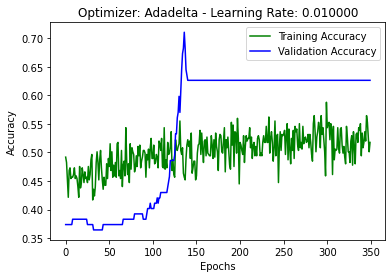

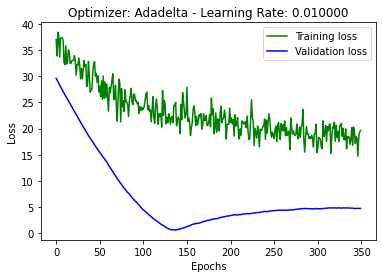

The training accuracy is: 0.5992509126663208
The training loss is: 4.612349987030029
The testing accuracy is: 0.659217877094972
The testing loss is: 3.7609992027282715

Epoch 1/350
14/14 [==============================] - 1s 17ms/step - loss: 54.6222 - accuracy: 0.3693 - val_loss: 47.3097 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 52.5765 - accuracy: 0.4154 - val_loss: 44.5206 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 46.2545 - accuracy: 0.4496 - val_loss: 41.9041 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 43.5168 - accuracy: 0.4574 - val_loss: 39.1217 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 41.9667 - accuracy: 0.4537 - val_loss: 36.8157 - val_accuracy: 0.3738
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 40.4747 - accuracy: 0.4579 - val_loss: 33.

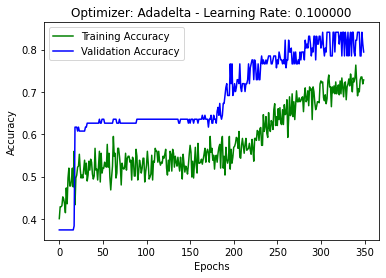

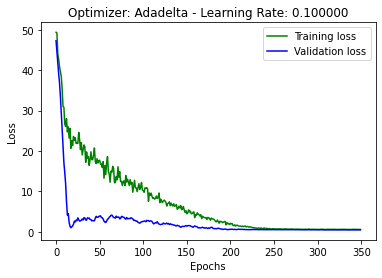

The training accuracy is: 0.7827715277671814
The training loss is: 0.4852840006351471
The testing accuracy is: 0.7988826815642458
The testing loss is: 0.4451678395271301

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 27.2118 - accuracy: 0.4911 - val_loss: 5.0555 - val_accuracy: 0.6449
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 21.1078 - accuracy: 0.4902 - val_loss: 4.5633 - val_accuracy: 0.6449
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 19.6190 - accuracy: 0.4849 - val_loss: 4.1447 - val_accuracy: 0.6449
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 17.2658 - accuracy: 0.5037 - val_loss: 6.4428 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 18.6406 - accuracy: 0.5288 - val_loss: 4.5047 - val_accuracy: 0.6449
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 15.0737 - accuracy: 0.5388 - val_loss: 3.8092

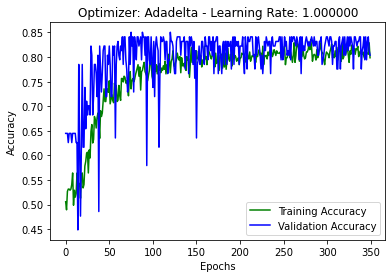

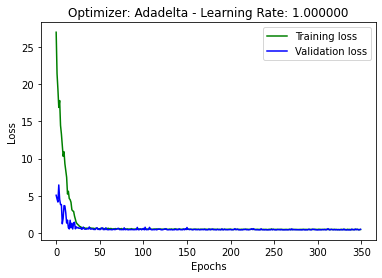

The training accuracy is: 0.8071160912513733
The training loss is: 0.45788097381591797
The testing accuracy is: 0.7932960893854749
The testing loss is: 0.48350226879119873

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 32.7895 - accuracy: 0.4761 - val_loss: 4.4056 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 29.8711 - accuracy: 0.4846 - val_loss: 2.7491 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 30.5228 - accuracy: 0.5139 - val_loss: 1.8714 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 29.6539 - accuracy: 0.4933 - val_loss: 0.8959 - val_accuracy: 0.3271
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 32.2954 - accuracy: 0.4488 - val_loss: 0.9774 - val_accuracy: 0.5234
Epoch 6/350
14/14 [==============================] - 0s 7ms/step - loss: 28.7593 - accuracy: 0.5033 - val_loss: 1.32

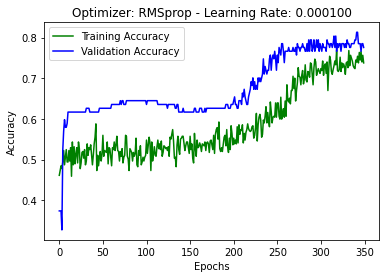

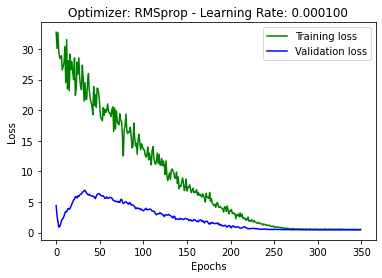

The training accuracy is: 0.7921348214149475
The training loss is: 0.4760124385356903
The testing accuracy is: 0.7653631284916201
The testing loss is: 0.44850191473960876

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 17.9124 - accuracy: 0.5005 - val_loss: 1.4794 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 19.5517 - accuracy: 0.4794 - val_loss: 2.0244 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 17.8584 - accuracy: 0.4648 - val_loss: 4.5163 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 9ms/step - loss: 15.7973 - accuracy: 0.5248 - val_loss: 5.6127 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 9ms/step - loss: 15.0075 - accuracy: 0.5131 - val_loss: 5.2010 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 11.2149 - accuracy: 0.5754 - val_loss: 4.193

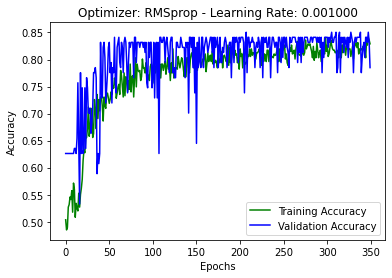

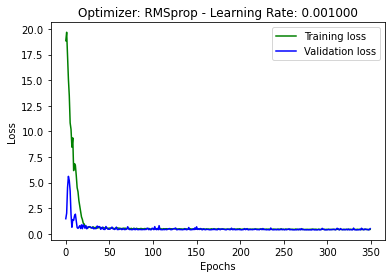

The training accuracy is: 0.7846441864967346
The training loss is: 0.4889352023601532
The testing accuracy is: 0.7877094972067039
The testing loss is: 0.5256175994873047

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 30.8205 - accuracy: 0.5330 - val_loss: 20.2185 - val_accuracy: 0.3832
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 22.1216 - accuracy: 0.4781 - val_loss: 2.2218 - val_accuracy: 0.4486
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 11.8937 - accuracy: 0.5510 - val_loss: 0.4553 - val_accuracy: 0.7664
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 5.9832 - accuracy: 0.5485 - val_loss: 0.6432 - val_accuracy: 0.6916
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 2.2647 - accuracy: 0.5645 - val_loss: 1.3151 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 0.9802 - accuracy: 0.6152 - val_loss: 0.7483 -

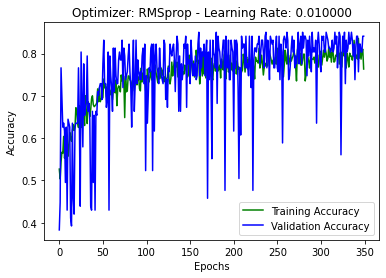

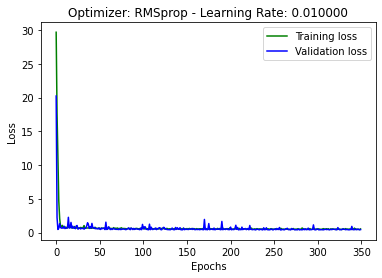

The training accuracy is: 0.8239700198173523
The training loss is: 0.4234289824962616
The testing accuracy is: 0.7988826815642458
The testing loss is: 0.5557257533073425

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 163.6132 - accuracy: 0.5511 - val_loss: 34.5907 - val_accuracy: 0.3832
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 22.2040 - accuracy: 0.5045 - val_loss: 0.7078 - val_accuracy: 0.4019
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 1.2856 - accuracy: 0.5177 - val_loss: 0.7280 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 1.0532 - accuracy: 0.5787 - val_loss: 1.8704 - val_accuracy: 0.4206
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 2.9210 - accuracy: 0.5088 - val_loss: 0.8275 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 2.6778 - accuracy: 0.5891 - val_loss: 0.9458 -

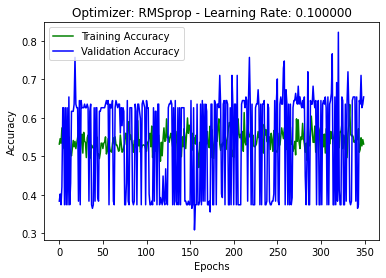

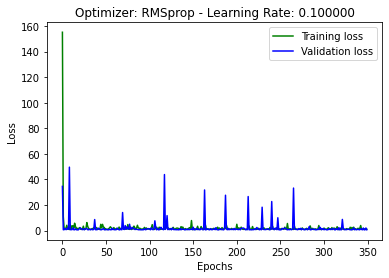

The training accuracy is: 0.6516854166984558
The training loss is: 0.6451432108879089
The testing accuracy is: 0.664804469273743
The testing loss is: 0.7662203311920166

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 5599.2071 - accuracy: 0.5027 - val_loss: 1.5252 - val_accuracy: 0.7570
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 5.9512 - accuracy: 0.5338 - val_loss: 6.5896 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 5.7835 - accuracy: 0.5010 - val_loss: 10.2315 - val_accuracy: 0.3832
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 15.9501 - accuracy: 0.4992 - val_loss: 220.2407 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 63.0614 - accuracy: 0.4946 - val_loss: 9.6853 - val_accuracy: 0.6168
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 5.3744 - accuracy: 0.5758 - val_loss: 7.837

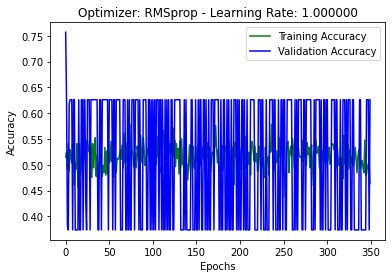

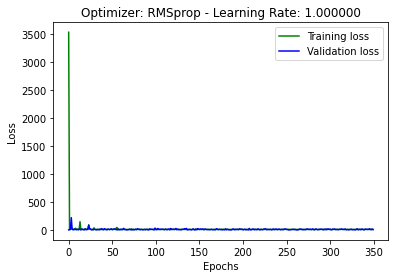

The training accuracy is: 0.5992509126663208
The training loss is: 5.644900798797607
The testing accuracy is: 0.659217877094972
The testing loss is: 4.8002142906188965

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 39.4890 - accuracy: 0.4248 - val_loss: 33.1047 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 42.9872 - accuracy: 0.4513 - val_loss: 32.5492 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 40.6806 - accuracy: 0.4600 - val_loss: 32.1076 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 41.0153 - accuracy: 0.4603 - val_loss: 31.7359 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 36.0363 - accuracy: 0.4607 - val_loss: 31.4741 - val_accuracy: 0.3738
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 45.3417 - accuracy: 0.4385 - val_loss: 31.

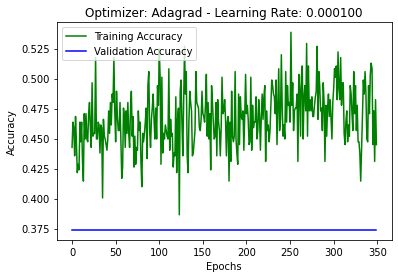

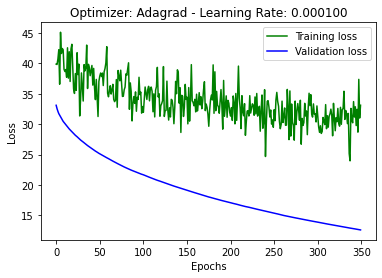

The training accuracy is: 0.4007490575313568
The training loss is: 12.395041465759277
The testing accuracy is: 0.33519553072625696
The testing loss is: 12.288448333740234

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 77.5849 - accuracy: 0.3813 - val_loss: 66.4013 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 72.0198 - accuracy: 0.4398 - val_loss: 61.1305 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 62.2465 - accuracy: 0.4085 - val_loss: 57.0806 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 62.6040 - accuracy: 0.4287 - val_loss: 53.8036 - val_accuracy: 0.3832
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 56.0030 - accuracy: 0.4224 - val_loss: 51.0191 - val_accuracy: 0.3832
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 53.1560 - accuracy: 0.4366 - val_loss: 

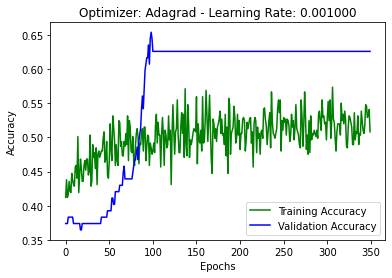

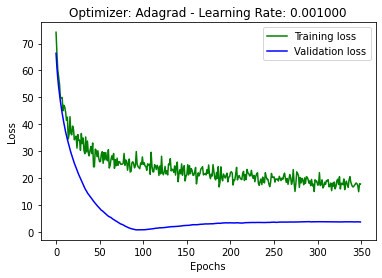

The training accuracy is: 0.5992509126663208
The training loss is: 3.570634126663208
The testing accuracy is: 0.664804469273743
The testing loss is: 2.8974127769470215

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 30.5965 - accuracy: 0.5521 - val_loss: 7.6662 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 20.9028 - accuracy: 0.5282 - val_loss: 4.6813 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 20.1260 - accuracy: 0.5322 - val_loss: 3.5389 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 23.9934 - accuracy: 0.5286 - val_loss: 4.0806 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 18.2443 - accuracy: 0.5567 - val_loss: 7.3122 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 15.8824 - accuracy: 0.5389 - val_loss: 5.8224 -

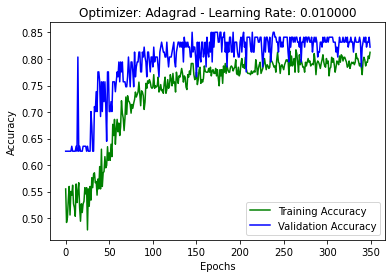

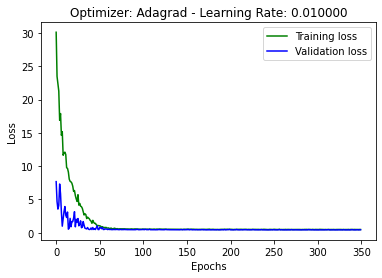

The training accuracy is: 0.8164793848991394
The training loss is: 0.45544153451919556
The testing accuracy is: 0.8044692737430168
The testing loss is: 0.4428878128528595

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 30.2067 - accuracy: 0.5437 - val_loss: 14.9739 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 7.7937 - accuracy: 0.5082 - val_loss: 1.6160 - val_accuracy: 0.3925
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 1.5829 - accuracy: 0.5117 - val_loss: 0.8848 - val_accuracy: 0.4206
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 1.0126 - accuracy: 0.4817 - val_loss: 0.6487 - val_accuracy: 0.6355
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 0.8609 - accuracy: 0.5574 - val_loss: 0.7899 - val_accuracy: 0.6355
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 0.7545 - accuracy: 0.5873 - val_loss: 0.6755 - 

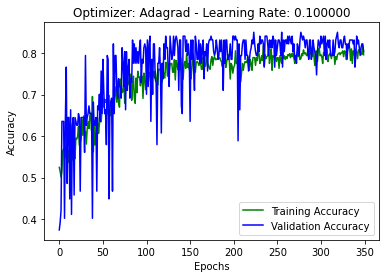

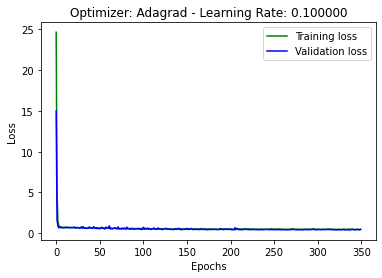

The training accuracy is: 0.8089887499809265
The training loss is: 0.45571815967559814
The testing accuracy is: 0.8100558659217877
The testing loss is: 0.4563129246234894

Epoch 1/350
14/14 [==============================] - 1s 39ms/step - loss: 233.7709 - accuracy: 0.5002 - val_loss: 1.3621 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 1.4111 - accuracy: 0.5374 - val_loss: 1.1853 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 1.7681 - accuracy: 0.5133 - val_loss: 0.7141 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 1.2772 - accuracy: 0.5003 - val_loss: 0.6731 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 1.3188 - accuracy: 0.4936 - val_loss: 0.8324 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 1.1798 - accuracy: 0.5033 - val_loss: 0.8391 - 

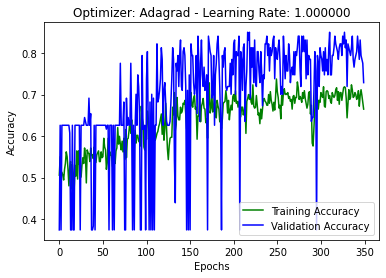

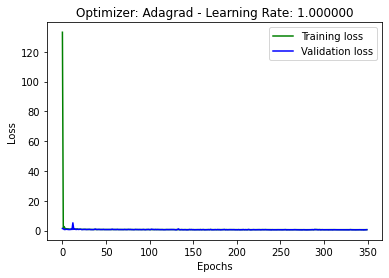

The training accuracy is: 0.6910112500190735
The training loss is: 0.5992164015769958
The testing accuracy is: 0.7318435754189944
The testing loss is: 0.568349301815033

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 19.0731 - accuracy: 0.5825 - val_loss: 4.7459 - val_accuracy: 0.6168
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 22.7931 - accuracy: 0.5465 - val_loss: 4.8594 - val_accuracy: 0.6168
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 22.2697 - accuracy: 0.5257 - val_loss: 4.9502 - val_accuracy: 0.6168
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 27.2987 - accuracy: 0.4914 - val_loss: 5.0770 - val_accuracy: 0.6168
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 26.3519 - accuracy: 0.5266 - val_loss: 5.1888 - val_accuracy: 0.6168
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 22.6969 - accuracy: 0.5216 - val_loss: 5.3449 

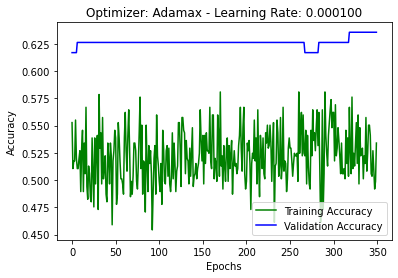

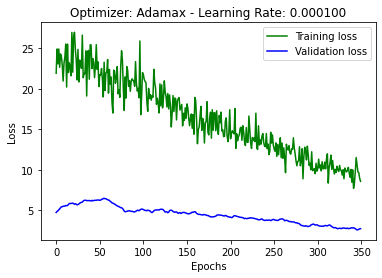

The training accuracy is: 0.6142321825027466
The training loss is: 2.618574857711792
The testing accuracy is: 0.664804469273743
The testing loss is: 2.1066300868988037

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 29.8267 - accuracy: 0.6060 - val_loss: 19.0717 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 24.3718 - accuracy: 0.5400 - val_loss: 13.9769 - val_accuracy: 0.6168
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 26.9124 - accuracy: 0.5308 - val_loss: 11.2390 - val_accuracy: 0.6262
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 26.3440 - accuracy: 0.5423 - val_loss: 9.8525 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 28.1210 - accuracy: 0.5039 - val_loss: 8.4058 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 25.9760 - accuracy: 0.4751 - val_loss: 7.599

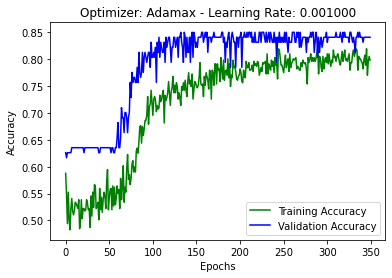

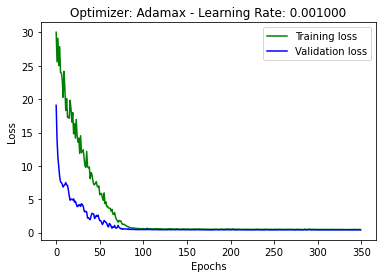

The training accuracy is: 0.8220973610877991
The training loss is: 0.43230223655700684
The testing accuracy is: 0.7821229050279329
The testing loss is: 0.4534895122051239

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 23.3960 - accuracy: 0.5269 - val_loss: 0.6190 - val_accuracy: 0.6636
Epoch 2/350
14/14 [==============================] - 0s 5ms/step - loss: 17.8805 - accuracy: 0.4855 - val_loss: 2.8646 - val_accuracy: 0.6355
Epoch 3/350
14/14 [==============================] - 0s 5ms/step - loss: 11.6104 - accuracy: 0.5245 - val_loss: 2.6050 - val_accuracy: 0.6449
Epoch 4/350
14/14 [==============================] - 0s 5ms/step - loss: 7.1401 - accuracy: 0.5181 - val_loss: 1.7554 - val_accuracy: 0.6449
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 5.1263 - accuracy: 0.5059 - val_loss: 0.6349 - val_accuracy: 0.6822
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 2.6843 - accuracy: 0.5361 - val_loss: 0.7180 -

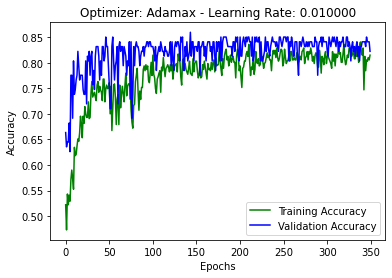

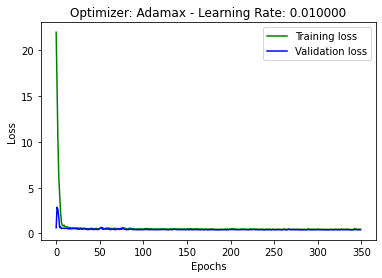

The training accuracy is: 0.8314606547355652
The training loss is: 0.40719953179359436
The testing accuracy is: 0.7877094972067039
The testing loss is: 0.47556623816490173

Epoch 1/350
14/14 [==============================] - 1s 15ms/step - loss: 52.9476 - accuracy: 0.5096 - val_loss: 11.4297 - val_accuracy: 0.6355
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 4.3401 - accuracy: 0.5447 - val_loss: 0.6206 - val_accuracy: 0.6449
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 0.8094 - accuracy: 0.5614 - val_loss: 0.6962 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 0.7397 - accuracy: 0.5444 - val_loss: 0.6585 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 0.7559 - accuracy: 0.5532 - val_loss: 0.6569 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 0.7784 - accuracy: 0.5004 - val_loss: 0.6553 -

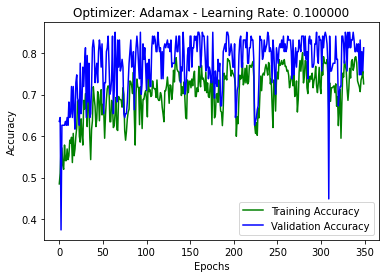

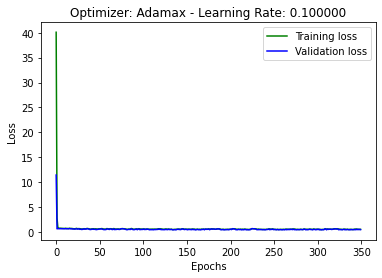

The training accuracy is: 0.8183520436286926
The training loss is: 0.43913114070892334
The testing accuracy is: 0.8212290502793296
The testing loss is: 0.5284349918365479

Epoch 1/350
14/14 [==============================] - 1s 22ms/step - loss: 1225.8082 - accuracy: 0.5539 - val_loss: 258.7274 - val_accuracy: 0.6262
Epoch 2/350
14/14 [==============================] - 0s 8ms/step - loss: 61.2294 - accuracy: 0.4986 - val_loss: 1.1522 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 7ms/step - loss: 4.7006 - accuracy: 0.5309 - val_loss: 0.6890 - val_accuracy: 0.6168
Epoch 4/350
14/14 [==============================] - 0s 7ms/step - loss: 4.6608 - accuracy: 0.4765 - val_loss: 2.1784 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 5ms/step - loss: 3.6232 - accuracy: 0.5374 - val_loss: 0.8431 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 5ms/step - loss: 3.9257 - accuracy: 0.5338 - val_loss: 1.187

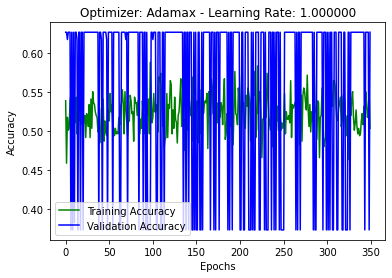

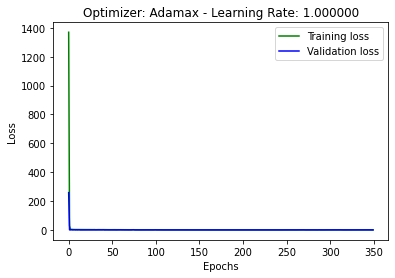

The training accuracy is: 0.5992509126663208
The training loss is: 0.7571165561676025
The testing accuracy is: 0.664804469273743
The testing loss is: 0.67342209815979

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 52.9738 - accuracy: 0.4159 - val_loss: 46.9514 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 52.2786 - accuracy: 0.4538 - val_loss: 44.9239 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 48.2808 - accuracy: 0.4414 - val_loss: 42.5754 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 48.4511 - accuracy: 0.4147 - val_loss: 40.2696 - val_accuracy: 0.3738
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 42.6023 - accuracy: 0.4431 - val_loss: 38.1508 - val_accuracy: 0.3738
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 47.1145 - accuracy: 0.4303 - val_loss: 35.8

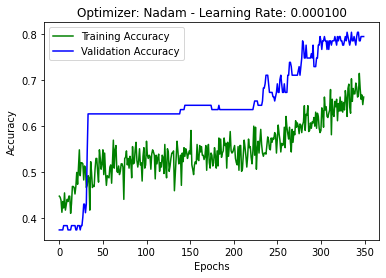

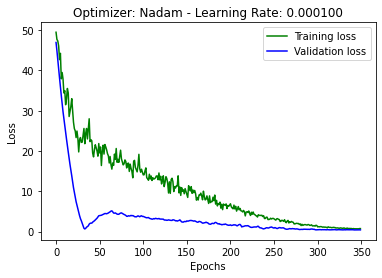

The training accuracy is: 0.7865168452262878
The training loss is: 0.46662992238998413
The testing accuracy is: 0.7988826815642458
The testing loss is: 0.4393514394760132

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 80.2666 - accuracy: 0.4073 - val_loss: 57.3346 - val_accuracy: 0.3832
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 62.2459 - accuracy: 0.4343 - val_loss: 34.0275 - val_accuracy: 0.3738
Epoch 3/350
14/14 [==============================] - 0s 7ms/step - loss: 35.0088 - accuracy: 0.4497 - val_loss: 15.0242 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 35.4348 - accuracy: 0.4581 - val_loss: 3.9773 - val_accuracy: 0.4393
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 25.1935 - accuracy: 0.5160 - val_loss: 3.1102 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 28.7497 - accuracy: 0.4844 - val_loss: 4.

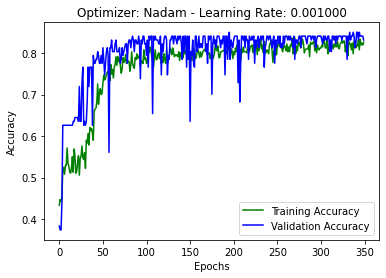

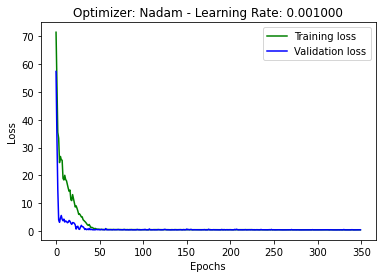

The training accuracy is: 0.8408239483833313
The training loss is: 0.41006630659103394
The testing accuracy is: 0.7821229050279329
The testing loss is: 0.48870936036109924

Epoch 1/350
14/14 [==============================] - 1s 17ms/step - loss: 32.8019 - accuracy: 0.4665 - val_loss: 5.0043 - val_accuracy: 0.4112
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 19.5396 - accuracy: 0.5315 - val_loss: 2.0683 - val_accuracy: 0.6262
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 11.5277 - accuracy: 0.5487 - val_loss: 1.7127 - val_accuracy: 0.6168
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 5.2666 - accuracy: 0.5935 - val_loss: 1.1512 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 3.0239 - accuracy: 0.5492 - val_loss: 1.1784 - val_accuracy: 0.6355
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 0.9751 - accuracy: 0.5789 - val_loss: 0.6378 

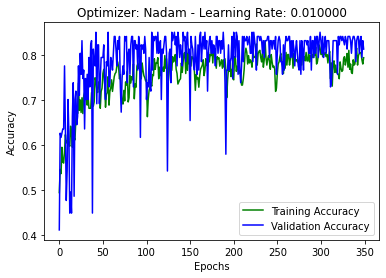

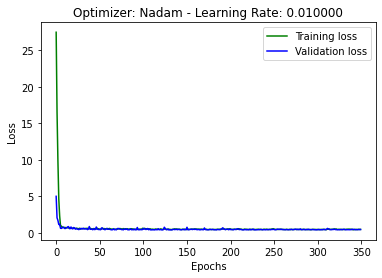

The training accuracy is: 0.8258426785469055
The training loss is: 0.4286815822124481
The testing accuracy is: 0.8100558659217877
The testing loss is: 0.5214603543281555

Epoch 1/350
14/14 [==============================] - 1s 17ms/step - loss: 42.6317 - accuracy: 0.5073 - val_loss: 1.6785 - val_accuracy: 0.5981
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 1.4338 - accuracy: 0.5800 - val_loss: 0.6656 - val_accuracy: 0.6168
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 0.7421 - accuracy: 0.5011 - val_loss: 0.6718 - val_accuracy: 0.6075
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5639 - val_loss: 0.6703 - val_accuracy: 0.6075
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 0.7774 - accuracy: 0.5412 - val_loss: 0.6635 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 0.7225 - accuracy: 0.5672 - val_loss: 0.7354 - va

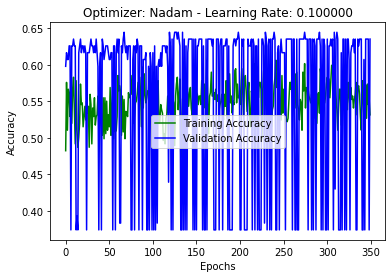

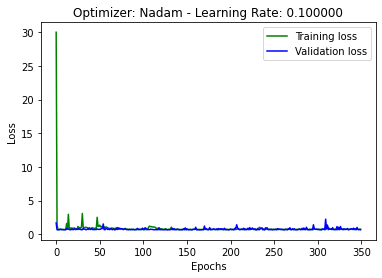

The training accuracy is: 0.6254681944847107
The training loss is: 0.6684959530830383
The testing accuracy is: 0.659217877094972
The testing loss is: 0.656186044216156

Epoch 1/350
14/14 [==============================] - 1s 16ms/step - loss: 1677.5616 - accuracy: 0.5005 - val_loss: 2.1868 - val_accuracy: 0.3738
Epoch 2/350
14/14 [==============================] - 0s 6ms/step - loss: 7.6066 - accuracy: 0.5074 - val_loss: 1.0486 - val_accuracy: 0.6168
Epoch 3/350
14/14 [==============================] - 0s 6ms/step - loss: 3.2958 - accuracy: 0.5080 - val_loss: 1.7958 - val_accuracy: 0.3738
Epoch 4/350
14/14 [==============================] - 0s 6ms/step - loss: 3.2838 - accuracy: 0.5132 - val_loss: 2.0524 - val_accuracy: 0.6262
Epoch 5/350
14/14 [==============================] - 0s 6ms/step - loss: 2.8462 - accuracy: 0.5807 - val_loss: 2.2357 - val_accuracy: 0.6262
Epoch 6/350
14/14 [==============================] - 0s 6ms/step - loss: 3.2961 - accuracy: 0.5144 - val_loss: 2.9935 - va

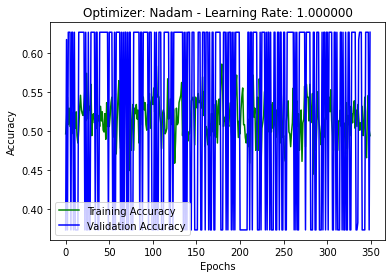

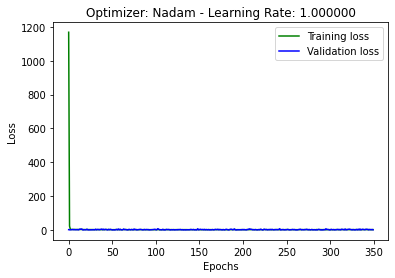

The training accuracy is: 0.601123571395874
The training loss is: 1.1583107709884644
The testing accuracy is: 0.664804469273743
The testing loss is: 0.9830893278121948



In [36]:
# List of optimizers and learning rates to be looped through
list_optimizers = ['Adam', 'SGD', 'Adadelta', 'RMSprop', 'Adagrad', 'Adamax', 'Nadam']
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1.0]

# Number of epochs per model
nn_epochs = 350

# Validation Split
val_split = 0.2

# Initializing a DataFrame to save each model results
nn_results = pd.DataFrame()

# Loop
for opt in list_optimizers:
    for lr in learning_rates:
        
        # Building a multilayer neural network using Keras
        model = Sequential()

        model.add(Dense(dims, input_dim = dims, activation = 'elu'))
        model.add(Dropout(0.50))
        model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model to provide the training parameters
        model.compile(optimizer = select_optimizer(opt, lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        # Train the model
        nn_history = model.fit(X_train, y_train, epochs = nn_epochs, verbose = 1, validation_split = val_split)
 
        # Evaluate the trained model on training data
        nn_train_eval = model.evaluate(X_train, y_train)
 
        # Evaluate the trained model
        nn_test_eval = model.evaluate(X_test, y_test)
        
        # Predicting using the testing data
        #y_test_pred = model.predict_classes(X_test)
        y_test_pred = (model.predict(X_test) > 0.5).astype("int32")
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # New row for results dataframe containing model hyperparameters and results
        
        new_row = {'optimizer': str(opt),
                   'learning_rate': lr,
                   'epochs': nn_epochs,
                   'validation_split': val_split,
                   'train_accuracy': nn_train_eval[1],
                   'train_log_loss': nn_train_eval[0],
                   'test_accuracy': test_accuracy,
                   'test_log_loss': nn_test_eval[0]
                   }
        
        nn_results = nn_results.append(new_row, ignore_index = True)
        
        # Plot Accuracy
        acc_train = nn_history.history['accuracy']
        acc_val = nn_history.history['val_accuracy']
        epochs = range(0, nn_epochs)
        plt.plot(epochs, acc_train, 'g', label = 'Training Accuracy')
        plt.plot(epochs, acc_val, 'b', label = 'Validation Accuracy')
        plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Plot Loss
        loss_train = nn_history.history['loss']
        loss_val = nn_history.history['val_loss']
        epochs = range(0, nn_epochs)
        plt.plot(epochs, loss_train, 'g', label = 'Training loss')
        plt.plot(epochs, loss_val, 'b', label = 'Validation loss')
        plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Printing metrics
        print(f"The training accuracy is: {nn_train_eval[1]}")
        print(f"The training loss is: {nn_train_eval[0]}")
        print(f"The testing accuracy is: {test_accuracy}")
        print(f"The testing loss is: {nn_test_eval[0]}")
        print()

In [37]:
nn_results = nn_results.sort_values(by='train_accuracy', ascending=False)
nn_results.head(50)

epochs  learning_rate optimizer  test_accuracy  test_log_loss  train_accuracy  train_log_loss  validation_split
1    350.0         0.0010      Adam       0.776536       0.500486        0.840824        0.400060               0.2
31   350.0         0.0010     Nadam       0.782123       0.488709        0.840824        0.410066               0.2
2    350.0         0.0100      Adam       0.776536       0.547890        0.838951        0.468128               0.2
27   350.0         0.0100    Adamax       0.787709       0.475566        0.831461        0.407200               0.2
32   350.0         0.0100     Nadam       0.810056       0.521460        0.825843        0.428682               0.2
17   350.0         0.0100   RMSprop       0.798883       0.555726        0.823970        0.423429               0.2
26   350.0         0.0010    Adamax       0.782123       0.453490        0.822097        0.432302               0.2
28   350.0         0.1000    Adamax       0.821229       0.528435        0.818352        0.439131               0.2
22   350.0         0.0100   Adagrad       0.804469       0.442888        0.816479        0.455442               0.2
0    350.0         0.0001      Adam       0.759777       0.448197        0.810861        0.459687               0.2
23   350.0         0.1000   Adagrad       0.810056       0.456313        0.808989        0.455718               0.2
14   350.0         1.0000  Adadelta       0.793296       0.483502        0.807116        0.457881               0.2
15   350.0         0.0001   RMSprop       0.765363       0.448502        0.792135        0.476012               0.2
30   350.0         0.0001     Nadam       0.798883       0.439351        0.786517        0.466630               0.2
16   350.0         0.0010   RMSprop       0.787709       0.525618        0.784644        0.488935               0.2
13   350.0         0.1000  Adadelta       0.798883       0.445168        0.782772        0.485284               0.2
24   350.0         1.0000   Adagrad       0.731844       0.568349        0.691011        0.599216               0.2
18   350.0         0.1000   RMSprop       0.664804       0.766220        0.651685        0.645143               0.2
33   350.0         0.1000     Nadam       0.659218       0.656186        0.625468        0.668496               0.2
25   350.0         0.0001    Adamax       0.664804       2.106630        0.614232        2.618575               0.2
5    350.0         0.0001       SGD       0.653631       0.708372        0.604869        0.785553               0.2
6    350.0         0.0010       SGD       0.664804       0.642616        0.602996        0.668498               0.2
10   350.0         0.0001  Adadelta       0.648045       2.936967        0.601124        3.641729               0.2
34   350.0         1.0000     Nadam       0.664804       0.983089        0.601124        1.158311               0.2
21   350.0         0.0010   Adagrad       0.664804       2.897413        0.599251        3.570634               0.2
7    350.0         0.0100       SGD       0.659218       0.649586        0.599251        0.672138               0.2
19   350.0         1.0000   RMSprop       0.659218       4.800214        0.599251        5.644901               0.2
29   350.0         1.0000    Adamax       0.664804       0.673422        0.599251        0.757117               0.2
4    350.0         1.0000      Adam       0.659218       1.889342        0.599251        2.221112               0.2
12   350.0         0.0100  Adadelta       0.659218       3.760999        0.599251        4.612350               0.2
8    350.0         0.1000       SGD       0.659218       0.642163        0.599251        0.685806               0.2
3    350.0         0.1000      Adam       0.363128       0.773275        0.447566        0.695052               0.2
11   350.0         0.0010  Adadelta       0.340782       3.541456        0.400749        3.586579               0.2
20   350.0         0.0001   Adagrad       0.335196      12.2

### Optimal Neural Network

Epoch 1/250
17/17 [==============================] - 1s 13ms/step - loss: 26.3847 - accuracy: 0.5367 - val_loss: 4.8901 - val_accuracy: 0.6236
Epoch 2/250
17/17 [==============================] - 0s 5ms/step - loss: 22.6160 - accuracy: 0.5329 - val_loss: 3.2029 - val_accuracy: 0.6236
Epoch 3/250
17/17 [==============================] - 0s 5ms/step - loss: 21.6385 - accuracy: 0.4802 - val_loss: 2.6675 - val_accuracy: 0.6236
Epoch 4/250
17/17 [==============================] - 0s 5ms/step - loss: 18.9087 - accuracy: 0.5376 - val_loss: 3.3161 - val_accuracy: 0.6236
Epoch 5/250
17/17 [==============================] - 0s 5ms/step - loss: 15.7238 - accuracy: 0.4968 - val_loss: 1.6936 - val_accuracy: 0.6180
Epoch 6/250
17/17 [==============================] - 0s 5ms/step - loss: 13.6936 - accuracy: 0.5179 - val_loss: 3.1719 - val_accuracy: 0.6180
Epoch 7/250
17/17 [==============================] - 0s 5ms/step - loss: 11.2625 - accuracy: 0.5436 - val_loss: 3.2270 - val_accuracy: 0.6180
Epoch

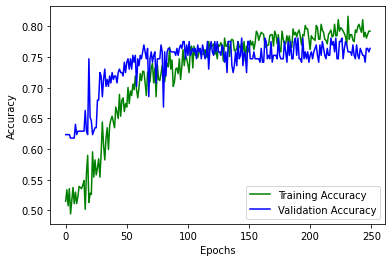

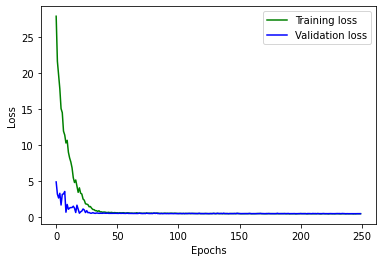

The training accuracy is: 0.8183520436286926
The training loss is: 0.44773873686790466
The testing accuracy is: 0.7821229050279329
The testing loss is: 0.43003419041633606



In [38]:
### Final Model used for Prediction        

# epochs
f_epochs = 250

# Building a multilayer neural network using Keras
fmodel = Sequential()
fmodel.add(Dense(dims, input_dim = dims, activation = 'elu'))
fmodel.add(Dropout(0.5))
fmodel.add(Dense(1, activation = 'sigmoid'))
        
# Compile the model to provide the training parameters
fmodel.compile(optimizer = tf.optimizers.Adagrad(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])        

# Train the model
nn_historyf = fmodel.fit(X_train, y_train, epochs = f_epochs, verbose = 1, validation_data = (X_val, y_val))

# Evaluate the trained model on training data
nn_train_eval = fmodel.evaluate(X_train, y_train)

# Evaluate the trained model
nn_test_eval = fmodel.evaluate(X_test, y_test)
        
# Predicting classes using the testing data
y_test_pred = (fmodel.predict(X_test) > 0.5).astype("int32")
#y_test_pred = fmodel.predict_classes(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Plot Accuracy
loss_train = nn_historyf.history['accuracy']
loss_val = nn_historyf.history['val_accuracy']
epochs = range(0, f_epochs)
plt.plot(epochs, loss_train, 'g', label = 'Training Accuracy')
plt.plot(epochs, loss_val, 'b', label = 'Validation Accuracy')
#plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
        
# Plot Loss
loss_train = nn_historyf.history['loss']
loss_val = nn_historyf.history['val_loss']
epochs = range(0, f_epochs)
plt.plot(epochs, loss_train, 'g', label = 'Training loss')
plt.plot(epochs, loss_val, 'b', label = 'Validation loss')
#plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
        
# Printing metrics
print(f"The training accuracy is: {nn_train_eval[1]}")
print(f"The training loss is: {nn_train_eval[0]}")
print(f"The testing accuracy is: {test_accuracy}")
print(f"The testing loss is: {nn_test_eval[0]}")
print()

## Output Submission File

In [51]:
# Logistic Classification prediction
predictions = lr2.predict(formatted_testing_data)

In [43]:
# Random Forest prediction
predictions = rfc.predict(formatted_testing_data)

In [39]:
# Neural Network prediction
#predictions = fmodel.predict(formatted_testing_data)
predictions = (fmodel.predict(formatted_testing_data) > 0.5).astype("int32")
predictions = np.squeeze(predictions)

In [52]:
# Output File
output = pd.DataFrame({'PassengerId' : test_data.PassengerId, 'Survived' : predictions})

In [53]:
output.head()

PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1

In [54]:
# Output submission file
output.to_csv('my_submission.csv', index = False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
